In [1]:
import torch
from torch import nn
from torch.nn import functional
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
'''
    pixel indices correspond to classes in alphabetical order 
    (1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle, 6=bus, 7=car , 
    8=cat, 9=chair, 10=cow, 11=diningtable, 12=dog, 13=horse, 14=motorbike, 
    15=person, 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor)
'''

'\n    pixel indices correspond to classes in alphabetical order \n    (1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle, 6=bus, 7=car , \n    8=cat, 9=chair, 10=cow, 11=diningtable, 12=dog, 13=horse, 14=motorbike, \n    15=person, 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor)\n'

In [2]:
train_tfs = transforms.Compose([
    transforms.Pad(200,255),
    transforms.CenterCrop((288, 288)),
    # transforms.Resize((256,256)),
    transforms.PILToTensor()
    # transforms.ConvertImageDtype(torch.float)
    # transforms.Normalize(mean=(0,0,0),std=(255,255,255))
])

In [3]:
target_tfs = transforms.Compose([
    transforms.Pad(200,255),
    transforms.CenterCrop((288, 288)),
    # transforms.Resize((256,256)),
    transforms.PILToTensor()
    # transforms.ConvertImageDtype(torch.float)
])

In [4]:
# data dir
root = '../data'
train_data = datasets.VOCSegmentation(
    root=root,
    image_set='train',
    download=False,
    transform=train_tfs,
    target_transform=target_tfs
    # transforms=target_tfs
)

val_data = datasets.VOCSegmentation(
    root=root,
    image_set='val',
    download=False,
    transform=train_tfs,
    target_transform=target_tfs
    # transforms=target_tfs
)
trainval_data = datasets.VOCSegmentation(
    root=root,
    image_set='trainval',
    download=False,
    transform=train_tfs,
    target_transform=target_tfs
)

In [5]:
print(f'training data size:{len(train_data)}')
print(f'validate data size:{len(val_data)}')
print(f'trainval data size:{len(trainval_data)}')

training data size:1464
validate data size:1449
trainval data size:2913


In [6]:
idx = 10

X,y = train_data[idx]

print(X.shape)
print(y.shape)

torch.Size([3, 288, 288])
torch.Size([1, 288, 288])
0
{0: 40782, 255: 3376, 19: 38786}


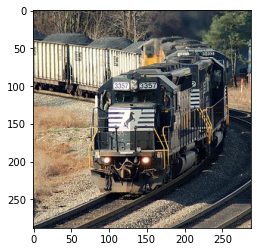

In [7]:
plt.imshow(transforms.ToPILImage()(X))

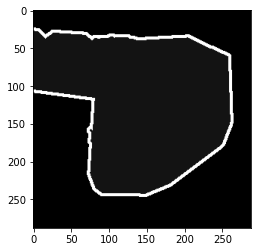

In [8]:
plt.imshow(transforms.ToPILImage()(y),cmap='gray')

In [7]:
batch_size = 32

train_dataloader = DataLoader(train_data,batch_size=batch_size,shuffle=True)
val_dataloader = DataLoader(val_data,batch_size=batch_size)
trainval_dataloader = DataLoader(trainval_data,batch_size=batch_size,shuffle=True,pin_memory=True)

In [8]:
# Convolutional downsampling block

class conv_block(nn.Module):
    
    def __init__(self,in_channels,channels = 32,dropout_prob=0, max_pooling=True):
        super(conv_block,self).__init__()
        self.in_channels = in_channels
        self.channels = channels
        self.dropout_prob = dropout_prob
        self.max_pooling = max_pooling
        self.conv1 = nn.Conv2d(in_channels=self.in_channels,
                               out_channels=self.channels,
                               kernel_size=3,
                               padding='same')
        self.conv2 = nn.Conv2d(in_channels=self.channels,
                               out_channels=self.channels,
                               kernel_size=3,
                               padding='same')
    def forward(self,inputs):
        conv = self.conv1(inputs)
        conv = functional.relu(conv)
        conv = self.conv2(conv)
        conv = functional.relu(conv)
        # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
        if self.dropout_prob>0:
            conv = functional.dropout(conv,self.dropout_prob)
        # if max_pooling is True add a MaxPooling2D with 2x2 pool_size    
        if self.max_pooling:
            next_layer = functional.max_pool2d(conv,kernel_size=2)
        else:
            next_layer = conv
            
        skip_connection = conv
        
        return next_layer,skip_connection

In [9]:
# 单元测试
inputs = torch.randn((2,3,288,288))
model = conv_block(3,32,0.5)
print(model)
print(inputs.shape)
block = model(inputs)
print(block[0].shape)

conv_block(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
)
torch.Size([2, 3, 288, 288])
torch.Size([2, 32, 144, 144])


In [10]:
# Convolutional upsampling block
class upsampling_block(nn.Module):
    def __init__(self,in_channels,channels):
        super(upsampling_block,self).__init__()
        self.channels = channels
        self.in_channels = in_channels
        self.up = nn.ConvTranspose2d(in_channels=self.in_channels,
                                     out_channels=self.channels,
                                     kernel_size=3,
                                     stride=2,
                                     padding=1,
                                     output_padding=1)
        self.conv1 = nn.Conv2d(in_channels=self.channels*2,
                               out_channels=self.channels,
                               kernel_size=3,
                               padding='same')
        self.conv2 = nn.Conv2d(in_channels=self.channels,
                               out_channels=self.channels,
                               kernel_size=3,
                               padding='same')
        
    def forward(self,expansive_input, contractive_input):
        
        up = self.up(expansive_input)
        merge = torch.cat((up,contractive_input),dim=1)
        conv = self.conv1(merge)
        conv = functional.relu(conv)
        conv = self.conv2(conv)
        conv = functional.relu(conv)
        return conv

In [11]:
# 单元测试
expansive_input = torch.randn((2,4,144,144))
contractive_input = torch.randn((2,10,288,288))
model = upsampling_block(4,10)
print(model)
output = model(expansive_input,contractive_input)
print(output.shape)

upsampling_block(
  (up): ConvTranspose2d(4, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (conv1): Conv2d(20, 10, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=same)
)
torch.Size([2, 10, 288, 288])


In [12]:
class unet_model(nn.Module):
    """
    Unet model
    input_size=(96, 128, 3), n_filters=32, n_classes=23
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    def __init__(self,in_channels,device,channels=32,classes=23):
        super(unet_model, self).__init__()
        self.in_channels = in_channels
        self.channels = channels
        self.classes = classes
        self.device = device
        self.cblock1 = conv_block(self.in_channels,self.channels,dropout_prob=0.5).to(device)
        self.cblock2 = conv_block(self.channels,self.channels*2,dropout_prob=0.5).to(device)
        self.cblock3 = conv_block(self.channels*2,self.channels*2*2,dropout_prob=0.5).to(device)
        self.cblock4 = conv_block(self.channels*2*2,self.channels*2*2*2,dropout_prob=0.3).to(device)
        self.cblock5 = conv_block(self.channels*2*2*2,self.channels*2*2*2*2,dropout_prob=0.3,max_pooling=False).to(device)
        self.ublock6 = upsampling_block(self.channels*2*2*2*2,self.channels*2*2*2).to(device)
        self.ublock7 = upsampling_block(self.channels*2*2*2,self.channels*2*2).to(device)
        self.ublock8 = upsampling_block(self.channels*2*2,self.channels*2).to(device)
        self.ublock9 = upsampling_block(self.channels*2,self.channels).to(device)
        self.conv1 = nn.Conv2d(in_channels=self.channels,
                               out_channels=self.channels,
                               kernel_size=3,
                               padding='same')
        self.conv2 = nn.Conv2d(in_channels=self.channels,
                               out_channels=self.classes,
                               kernel_size=1,
                               padding='same')
    def forward(self,inputs):
        # downsampling encoder
        cblock1 = self.cblock1(inputs)
        cblock2 = self.cblock2(cblock1[0])
        cblock3 = self.cblock3(cblock2[0])
        cblock4 = self.cblock4(cblock3[0])
        cblock5 = self.cblock5(cblock4[0])
        
        #upsampling decoder
        ublock6 = self.ublock6(cblock5[0],cblock4[1])
        ublock7 = self.ublock7(ublock6,cblock3[1])
        ublock8 = self.ublock8(ublock7,cblock2[1])
        ublock9 = self.ublock9(ublock8,cblock1[1])
        
        conv = self.conv1(ublock9)
        conv = functional.relu(conv)
        conv = self.conv2(conv)
        return conv

In [ ]:
## 单元测试
model = unet_model(3,32,22)
print(model)
inputs = torch.randn(2,3,288,288)
print(model(inputs).shape)

In [13]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [14]:
channels = 32 
classes = 21 # 22 classes
input_channels = 3
model = unet_model(input_channels,device,channels,classes).to(device)
# print(model)

In [17]:
lr = 0.0001
# loss function
# loss_fn = nn.CrossEntropyLoss(ignore_index=255)
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([0.2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]).to(torch.float).to(device),ignore_index=255)
# optimizer
# optimizer = torch.optim.Adam(model.parameters(),lr=lr)
optimizer = torch.optim.SGD(model.parameters(),lr=lr,momentum=0.99)

In [18]:
# train process
def train(dataloader, device, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # X,y= X.to(torch.float).to(device),y.to(torch.long).to(device)
        # X /= 255 
        X= X.to(torch.float).to(device)
        # reshape
        y = y.view(-1,y.shape[2],y.shape[3])
        y = y.to(torch.long).to(device)
        # print(y)
        # change 255 to 0
        # y_copy = torch.clone(y).to(torch.long).to(device)
        # print(y_copy)
        # y_copy = torch.where(y_copy==255,0,y_copy)
        # print(y_copy)
        # y_copy = y_copy.to(torch.long).to(device)
        # Compute prediction error
        pred = model(X)
        # print(pred)
        # loss = loss_fn(pred, y_copy)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 30 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [19]:
def test(dataloader, device,model, loss_fn,threshold):
    # size = len(dataloader.dataset)
    total_size = 0
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            # X,y= X.to(torch.float).to(device),y.to(torch.long).to(device)
            # X /= 255 
            X= X.to(torch.float).to(device)
            # reshape
            y = y.view(-1,y.shape[2],y.shape[3])
            y = y.to(torch.long).to(device)
            # change 255 to 0
            # y_copy = torch.clone(y).to(torch.long).to(device)
            # y_copy = torch.where(y_copy==255,0,y_copy)
            
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            pred = nn.Softmax(dim=1)(pred)
            # print(pre)
            # pred = torch.where(pred < threshold,torch.tensor(0).to(torch.float).to(device),pred)
            # pred[:,0,:,:] = 0.05
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            total_size += (y != 255).type(torch.float).sum().item()
    test_loss /= num_batches
    # print(y.shape)
    # correct /= size*y.shape[2]*y.shape[2]
    correct /= total_size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.2f}%, Avg loss: {test_loss:>8f} \n")

In [20]:
epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    # train(train_dataloader, device, model, loss_fn, optimizer)
    # test(val_dataloader, device, model, loss_fn)
    train(trainval_dataloader, device, model, loss_fn, optimizer)
    test(trainval_dataloader,device,model,loss_fn,0.2)
print("Done!")

Epoch 1
-------------------------------
loss: 3.924608  [    0/ 2913]
loss: 2.745952  [  960/ 2913]
loss: 2.566194  [ 1920/ 2913]
loss: 2.377921  [ 2880/ 2913]
Test Error: 
 Accuracy: 61.17%, Avg loss: 2.381705 

Epoch 2
-------------------------------
loss: 2.424559  [    0/ 2913]
loss: 2.402893  [  960/ 2913]
loss: 2.345863  [ 1920/ 2913]
loss: 2.617812  [ 2880/ 2913]
Test Error: 
 Accuracy: 61.17%, Avg loss: 2.341541 

Epoch 3
-------------------------------
loss: 2.172700  [    0/ 2913]
loss: 2.212447  [  960/ 2913]
loss: 2.245772  [ 1920/ 2913]
loss: 2.447269  [ 2880/ 2913]
Test Error: 
 Accuracy: 61.17%, Avg loss: 2.407108 

Epoch 4
-------------------------------
loss: 2.542581  [    0/ 2913]
loss: 2.424745  [  960/ 2913]
loss: 2.498422  [ 1920/ 2913]
loss: 2.343398  [ 2880/ 2913]
Test Error: 
 Accuracy: 61.17%, Avg loss: 2.307869 

Epoch 5
-------------------------------
loss: 2.380925  [    0/ 2913]
loss: 2.051742  [  960/ 2913]
loss: 2.179450  [ 1920/ 2913]
loss: 2.274292  [ 

In [42]:
torch.save(model,'u_net_model_2_ignore_index')

In [23]:
model = torch.load('u_net_model_ignore_index',map_location=device)

In [21]:
def predict(img,model,device):
    img = torch.unsqueeze(img,0) # shape is (N,C,H,W). N is batch size 
    img = img.to(torch.float).to(device)
    with torch.no_grad():
        pred = model(img)
        pred = nn.Softmax(dim=1)(pred)
        pred = pred.argmax(1)
        # pred = nn.Softmax(dim=1)(pred).argmax(1)
        # pred = pred.argmax(1)
        # pred = torch.where(pred == 21,255,pred)
    return pred.to(torch.float)

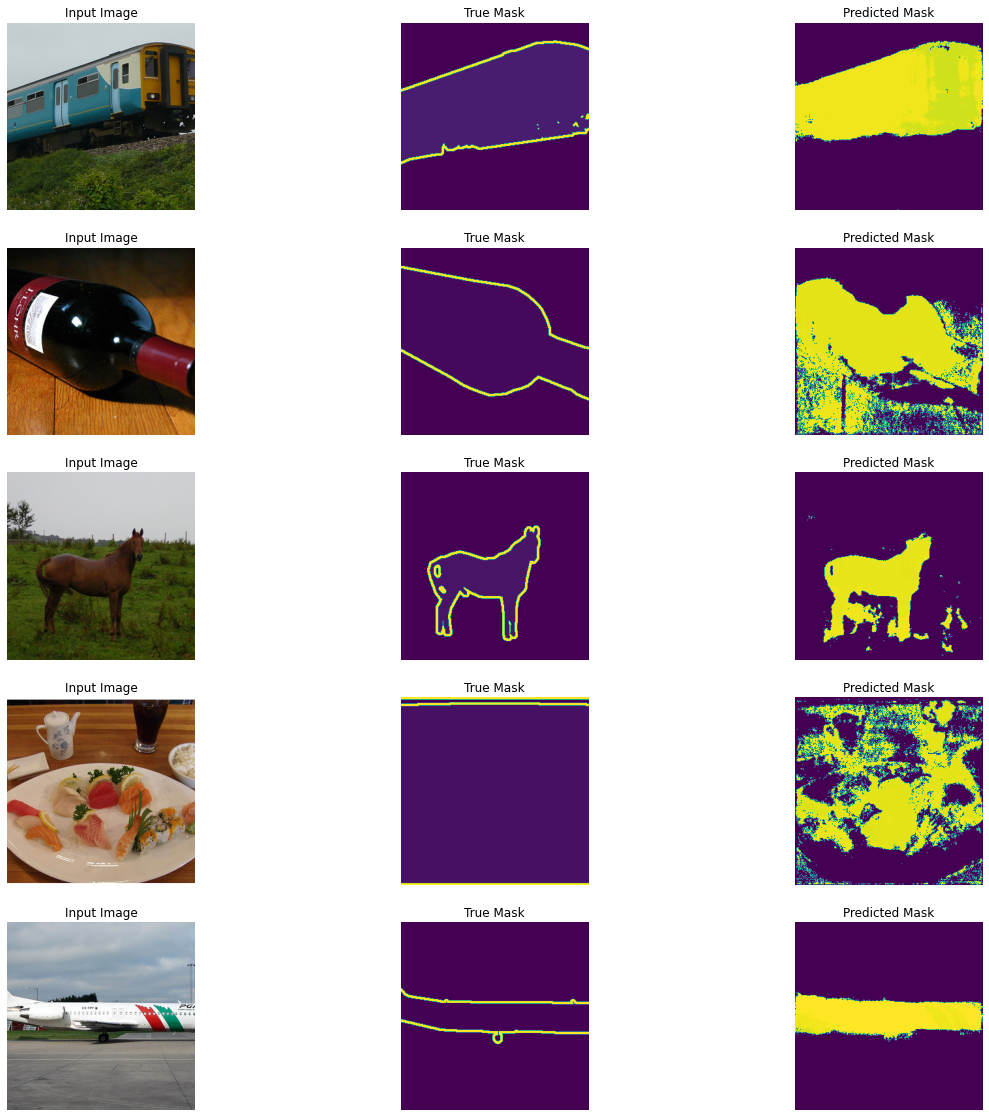

In [50]:
# torch.manual_seed(17)
rows,cols = 5,3
title = ['Input Image', 'True Mask', 'Predicted Mask']
plt.figure(figsize=(20, 20))
data = trainval_data
for i in range(rows):
    idx = torch.randint(len(data),(1,)).item()
    img_list = [data[idx][0],data[idx][1].to(torch.float),predict(data[idx][0],model,device)]
    for j,img in enumerate(img_list):
        plt.subplot(rows,cols,i*cols+j+1)
        plt.title(title[j])
        plt.imshow(transforms.ToPILImage()(img))
        plt.axis('off')
plt.show()